# APTOS 2019 Blindness Detection

ref:https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping

## Ben Crop

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import os
from pathlib import Path
from IPython.display import Image as display_image
from IPython.display import display
print(os.listdir("../input"))

import cv2
from PIL import Image
import imagesize
from scipy import ndimage

['test.csv', 'train.csv', 'sample_submission.csv', 'train_images', 'test_images', 'aptos2019-blindness-detection']


### data load

In [2]:
train_df = pd.read_csv("../input/train.csv")

### define function

In [3]:
def load_image(id):
    img_path = Path().absolute().parent / "input" / "train_images" / "{}.png".format(id)
    
    if img_path.exists():
        d_level = int(train_df.query("id_code == '{}'".format(id)).iloc[0, 1]) 
        diagnosis_dict = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
    else:
        img_path = Path().absolute().parent / "input" / "test_images" / "{}.png".format(id)
        
    return cv2.imread(str(img_path))

### crop code

In [7]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [11]:
def load_ben_color(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (512, 512))
    image = cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [7]:
class BenColorCrop(object):
    def __init__(self, img_size=512, sigmaX=10, tol=7):
        self.img_size = 512
        self.sigmaX = sigmaX
        self.tol = tol
        
    def __call__(self, img):
        img = self._load_ben_color(img)
        return img
    
    def _load_ben_color(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self._crop_image_from_gray(img)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), self.sigmaX), -4, 128)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
        
    def _crop_image_from_gray(self, img):
        if img.ndim == 2:
            mask = img > self.tol
            return img[np.ix_(mask.any(1), mask.any(0))]
        elif img.ndim == 3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img > self.tol
            
            check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
            if check_shape == 0:
                return img
            else:
                img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
                img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
                img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
                img = np.stack([img1, img2, img3], axis=-1)
            return img

resizeしてからaddWeightedすると画像がより鮮明？になる。そのへんは使えそう。

### test section

In [5]:
 f_list = ["005b95c28852", "00cb6555d108", "01499815e469", "0167076e7089"]

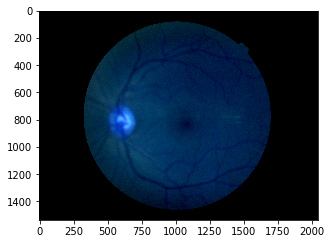

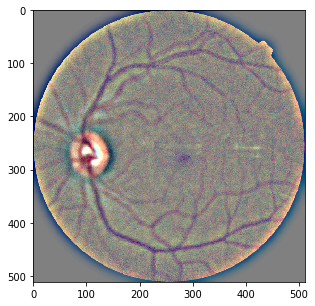

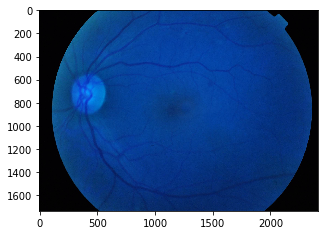

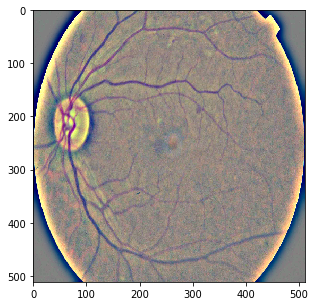

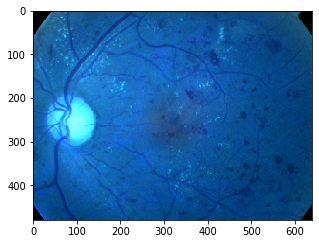

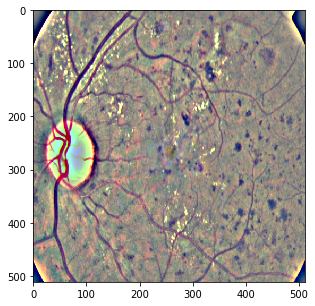

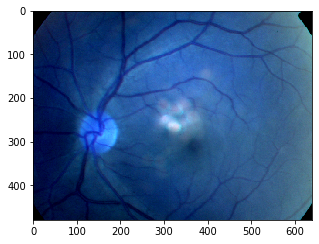

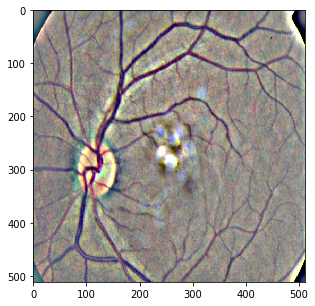

In [13]:
for f in f_list:
    img = load_image(f)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    img = load_ben_color(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)

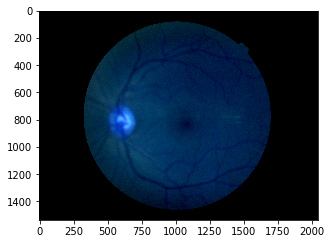

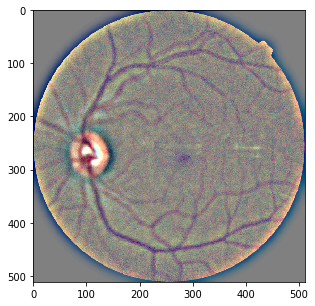

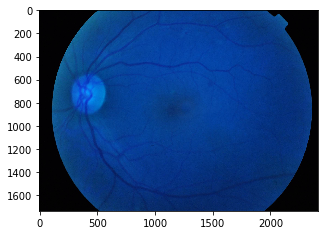

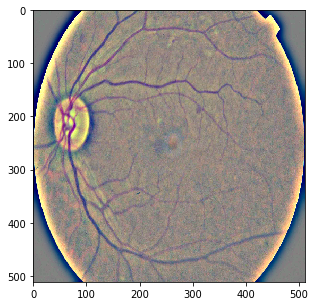

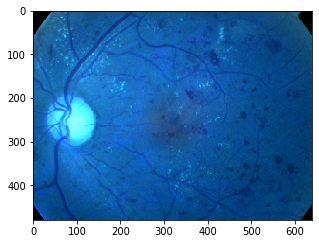

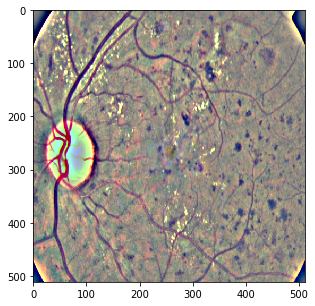

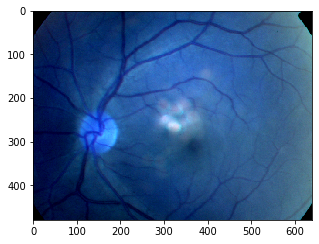

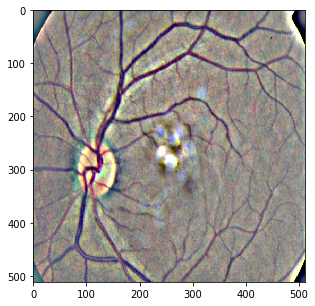

In [8]:
cropper = BenColorCrop()
for f in f_list:
    img = load_image(f)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    img = cropper(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)